In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
df = pd.read_csv("customer_complaints.csv")
df

,complaint_id,complaint_text
0,1,My order was supposed to arrive yesterday but ...
1,2,The product arrived broken and the packaging w...
2,3,I was charged twice for the same order and no ...
3,4,The delivery was delayed by five days without ...
4,5,I received the wrong item instead of what I or...
5,6,The app crashes every time I try to make a pay...
6,7,My refund has been pending for two weeks after...
7,8,The product quality is very poor and looks used
8,9,The order status shows delivered but I never r...
9,10,I was billed even after cancelling my subscrip...


In [23]:
texts = df["complaint_text"].astype(str).tolist()

 Load sentence embedding model

In [24]:
model = SentenceTransformer("all-MiniLM-L6-v2")
embedding =model.encode(texts,show_progress_bar=True)


Batches: 100%|██████████| 1/1 [00:00<00:00,  9.51it/s]


 KMeans clustering

In [25]:
wcss=[]
for i in range(1,11):
    data=KMeans(n_clusters=i,init='k-means++',random_state=42)
    data.fit(embedding)
    wcss.append(data.inertia_)#calculate bvariance
wcss

[20.625991821289062,
 19.420745849609375,
 16.71303939819336,
 16.22112464904785,
 14.905680656433105,
 13.471294403076172,
 12.75684928894043,
 11.759541511535645,
 10.918342590332031,
 10.161876678466797]

Text(0.5, 1.0, 'Elbow Points')

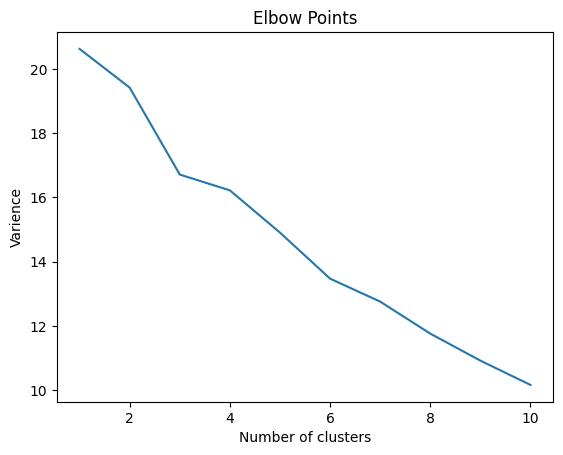

In [26]:
plt.plot(range(1,11),wcss)
plt.xlabel("Number of clusters")
plt.ylabel("Varience")
plt.title("Elbow Points")

In [27]:
data1=KMeans(n_clusters=7,init='k-means++',random_state=42)
data1.fit(embedding)
y_pred=data1.predict(embedding)
df["cluster"] = y_pred

Inspect clusters

In [28]:

for cluster_id in range(7):
    print("\n" + "=" * 40)
    print(f"Cluster {cluster_id}")
    print("=" * 60)

    sample_texts = df[df["cluster"] == cluster_id]["complaint_text"].head(5)
    for text in sample_texts:
        print("-", text)


Cluster 0
- The app crashes every time I try to make a payment
- Customer support is not responding to my complaint emails
- The product stopped working within two days of delivery
- I want to return the product but the return option is not available in the app
- I received a damaged product and customer care refused replacement

Cluster 1
- I was charged twice for the same order and no refund has been issued
- My refund has been pending for two weeks after cancellation
- I was billed even after cancelling my subscription
- Payment failed but the amount was deducted from my account
- I am unable to apply the discount coupon at checkout

Cluster 2
- I received the wrong item instead of what I ordered
- I received someone else’s order instead of mine

Cluster 3
- I received an incomplete order with missing items
- The website is very slow and pages are not loading properly
- My order has been stuck in transit for several days
- The app logs me out automatically while placing an order
- 

Manually assign cluster meanings

In [29]:
cluster_to_root_cause = {
    0: "Customer Support / Product Issue Handling",
    1: "Payment / Billing / Refund Issue",
    2: "Wrong Item Delivered",
    3: "App / Website Technical Issues (Mixed)",
    4: "Delivery Delay / Delivery Failure",
    5: "Damaged / Poor Quality Product",
    6: "Product Description Mismatch"
}


In [30]:
df.to_csv("clustered_complaints.csv", index=False)

print("\nClustered dataset saved as clustered_complaints.csv")


Clustered dataset saved as clustered_complaints.csv


 Predict root cause for NEW complaint

In [31]:
def predict_root_cause(new_complaint):
    new_embedding = model.encode([new_complaint])
    cluster_id = data1.predict(new_embedding)[0]

    similarities = cosine_similarity(
        new_embedding,
        embedding[df["cluster"] == cluster_id]
    )

    confidence = float(np.max(similarities))

    return {
        "complaint": new_complaint,
        "predicted_cluster": int(cluster_id),
        "predicted_root_cause": cluster_to_root_cause.get(cluster_id, "Unknown"),
        "confidence": round(confidence, 3)
    }

In [32]:
test_complaint = "I paid for the order but it never arrived and tracking is stuck"

result = predict_root_cause(test_complaint)

print("\nPrediction Result")
print(result)


Prediction Result
{'complaint': 'I paid for the order but it never arrived and tracking is stuck', 'predicted_cluster': 4, 'predicted_root_cause': 'Delivery Delay / Delivery Failure', 'confidence': 0.792}
